## 初始化

In [1]:
import pandas as pd
import numpy as np
from arch import arch_model

import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from copulae.marginal import MarginalCopula
from copulae.empirical import EmpiricalCopula
from copulae.indep import IndepCopula
from copulae.elliptical import GaussianCopula, StudentCopula
from copulae.archimedean import ClaytonCopula, FrankCopula, GumbelCopula
from copulae import pseudo_obs  # Utility for 伪观测

plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

## 数据预处理

In [2]:
BTC = pd.read_csv('../data/Bitcoin历史数据.csv',index_col = 0)
ETH = pd.read_csv('../data/Ethereum历史数据.csv',index_col = 0)
XAU = pd.read_csv('../data/XAU_USD历史数据.csv',index_col = 0)
SPX = pd.read_csv('../data/美国标准普尔500指数历史数据.csv',index_col = 0)

In [3]:
align_index = SPX.index

In [4]:
closes = [BTC.loc[align_index]['收盘'].str.replace(',',''),
          ETH.loc[align_index]['收盘'].str.replace(',',''),
          SPX.loc[align_index]['收盘'].str.replace(',',''),
          XAU.loc[align_index]['收盘'].str.replace(',','')]
working_df = pd.concat(closes,axis=1)
working_df.columns = ['BTC','ETH','SPX','XAU']
working_df = working_df.astype(float)
working_df.index = pd.to_datetime(working_df.index)
log_ret  = np.log(working_df).diff().dropna()

In [38]:
[display(name,group.corr()) for name,group in working_df.groupby(working_df.index.year)]
[display(name,group.corr()) for name,group in log_ret.groupby(log_ret.index.year)]
log_ret.describe()

2021

,BTC,ETH,SPX,XAU
BTC,1.000000,0.546265,0.280730,-0.424979
ETH,0.546265,1.000000,0.868450,0.000677
SPX,0.280730,0.868450,1.000000,-0.021694
XAU,-0.424979,0.000677,-0.021694,1.000000


2022

,BTC,ETH,SPX,XAU
BTC,1.000000,0.975879,0.868451,0.755134
ETH,0.975879,1.000000,0.905018,0.691621
SPX,0.868451,0.905018,1.000000,0.651469
XAU,0.755134,0.691621,0.651469,1.000000


2023

,BTC,ETH,SPX,XAU
BTC,1.000000,0.904379,0.729777,0.685834
ETH,0.904379,1.000000,0.626390,0.747318
SPX,0.729777,0.626390,1.000000,0.387237
XAU,0.685834,0.747318,0.387237,1.000000


2024

,BTC,ETH,SPX,XAU
BTC,1.000000,0.630782,0.760195,0.646930
ETH,0.630782,1.000000,0.176361,0.010490
SPX,0.760195,0.176361,1.000000,0.910479
XAU,0.646930,0.010490,0.910479,1.000000


2025

,BTC,ETH,SPX,XAU
BTC,1.000000,0.822264,0.791269,0.544594
ETH,0.822264,1.000000,0.875591,0.505817
SPX,0.791269,0.875591,1.000000,0.690116
XAU,0.544594,0.505817,0.690116,1.000000


2021

,BTC,ETH,SPX,XAU
BTC,1.000000,0.751278,0.274711,-0.057903
ETH,0.751278,1.000000,0.247732,0.022937
SPX,0.274711,0.247732,1.000000,0.151978
XAU,-0.057903,0.022937,0.151978,1.000000


2022

,BTC,ETH,SPX,XAU
BTC,1.000000,0.904812,0.560972,0.139163
ETH,0.904812,1.000000,0.546193,0.124560
SPX,0.560972,0.546193,1.000000,0.194101
XAU,0.139163,0.124560,0.194101,1.000000


2023

,BTC,ETH,SPX,XAU
BTC,1.000000,0.853477,0.151674,0.103835
ETH,0.853477,1.000000,0.151855,0.104792
SPX,0.151674,0.151855,1.000000,-0.013418
XAU,0.103835,0.104792,-0.013418,1.000000


2024

,BTC,ETH,SPX,XAU
BTC,1.000000,0.820476,0.366613,0.092178
ETH,0.820476,1.000000,0.400753,0.117460
SPX,0.366613,0.400753,1.000000,0.239333
XAU,0.092178,0.117460,0.239333,1.000000


2025

,BTC,ETH,SPX,XAU
BTC,1.000000,0.801473,0.424022,0.077800
ETH,0.801473,1.000000,0.461157,-0.009235
SPX,0.424022,0.461157,1.000000,-0.023464
XAU,0.077800,-0.009235,-0.023464,1.000000


,BTC,ETH,SPX,XAU
count,1221.000000,1221.000000,1221.000000,1221.000000
mean,-0.000946,-0.000972,-0.000504,-0.000631
std,0.037328,0.049358,0.010747,0.009729
min,-0.191820,-0.252588,-0.090895,-0.035227
25%,-0.019503,-0.025815,-0.006245,-0.006213
50%,-0.000323,-0.001112,-0.000824,-0.000753
75%,0.017560,0.023860,0.004691,0.004703
max,0.258963,0.326921,0.061609,0.054579


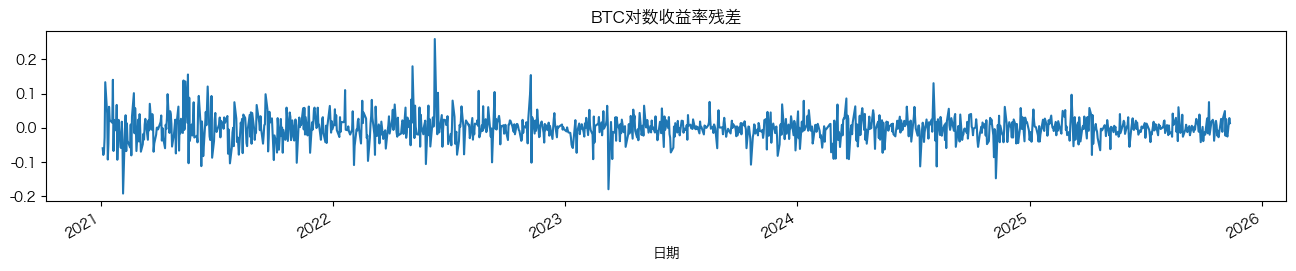

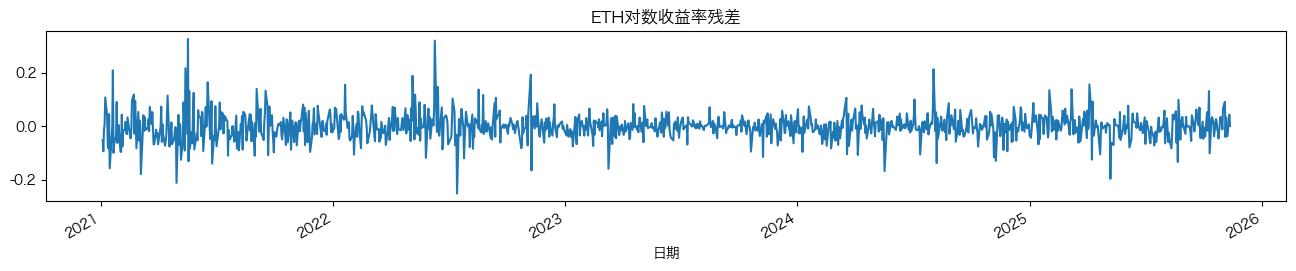

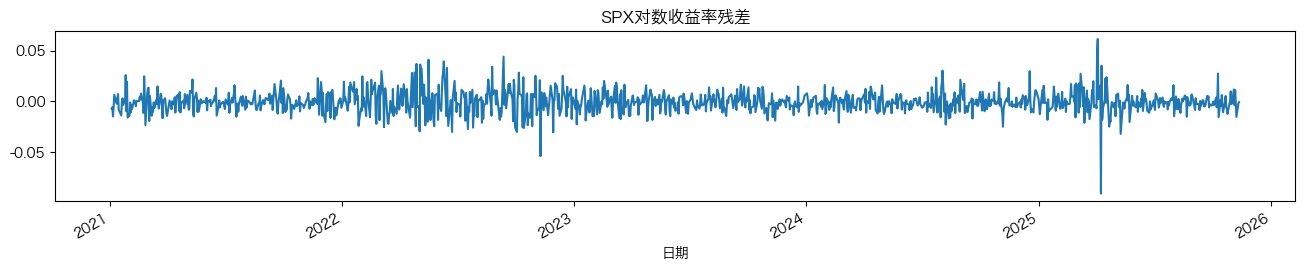

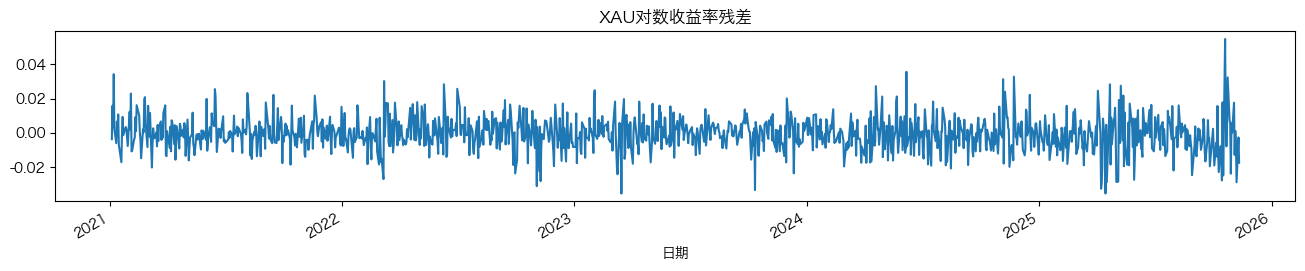

In [32]:
[(log_ret[col].plot(figsize=(16,2.5),title=col+'对数收益率残差'),plt.show()) for col in log_ret.columns]
_ =0

## garch拟合

In [33]:
std_resid = pd.DataFrame(index=log_ret.index)
model_table = {}
for col in log_ret.columns:
    try:
        model = arch_model(log_ret[col] * 100, vol='Garch', p=1, q=1, dist='normal')
        res = model.fit(disp='off')
        std_resid[col] = res.resid / res.conditional_volatility
        print(f"GARCH {col}: alpha={res.params.get('alpha[1]', np.nan):.3f}, beta={res.params.get('beta[1]', np.nan):.3f}")
    except Exception as e:
        print(f"GARCH {col}: 失败 ({e}) - 数据太少？")
std_resid = std_resid.dropna()

GARCH BTC: alpha=0.078, beta=0.903
GARCH ETH: alpha=0.050, beta=0.940
GARCH SPX: alpha=0.121, beta=0.855
GARCH XAU: alpha=0.051, beta=0.901


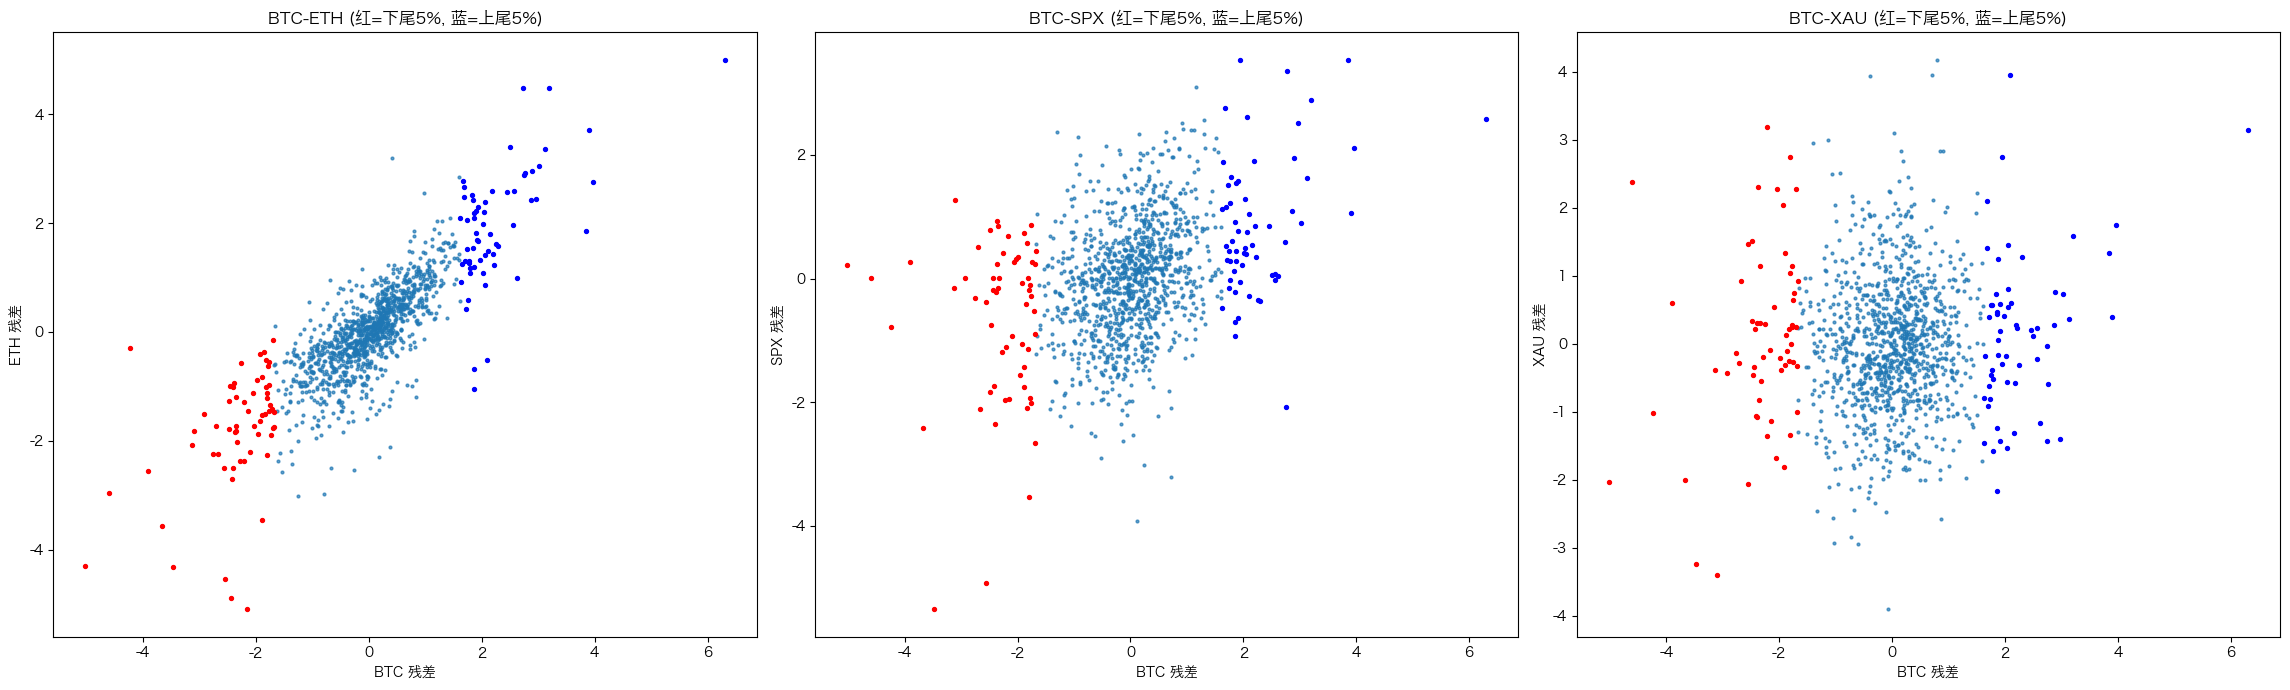

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(23, 7))
pairs = [('BTC', 'ETH'), ('BTC', 'SPX'), ('BTC', 'XAU')]
for idx, (x, y) in enumerate(pairs):
    # r, c = divmod(idx, 2)
    axes[idx].scatter(std_resid[x], std_resid[y], alpha=0.7, s=4)
    axes[idx].set_xlabel(f'{x} 残差'); axes[idx].set_ylabel(f'{y} 残差')
    axes[idx].set_title(f'{x}-{y} (红=下尾5%, 蓝=上尾5%)')
    # 高亮尾部
    q = 0.05; xl = std_resid[x].quantile(q); xh = std_resid[x].quantile(1-q)
    low = std_resid[x] < xl; high = std_resid[x] > xh
    axes[idx].scatter(std_resid[x][low], std_resid[y][low], c='red', s=8, zorder=5)
    axes[idx].scatter(std_resid[x][high], std_resid[y][high], c='blue', s=8, zorder=5)
plt.tight_layout()
plt.show()


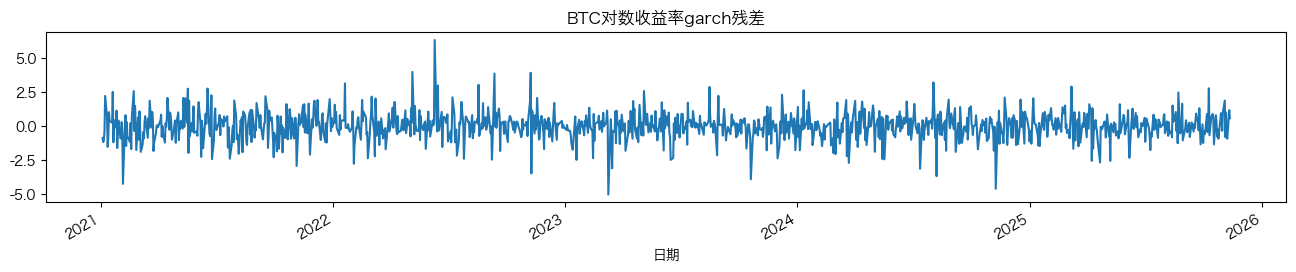

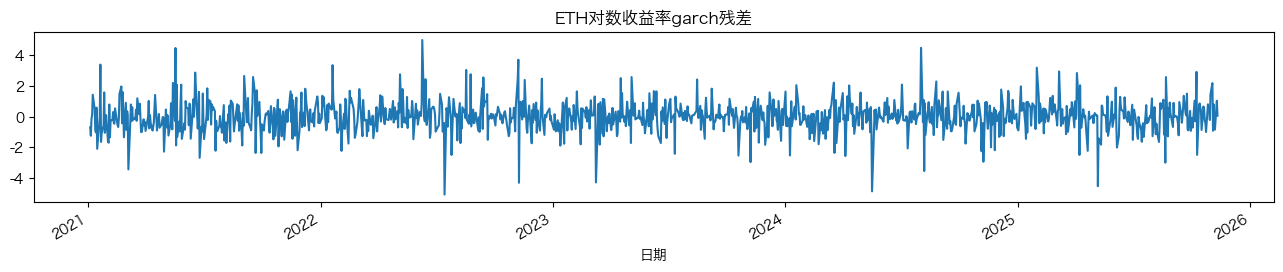

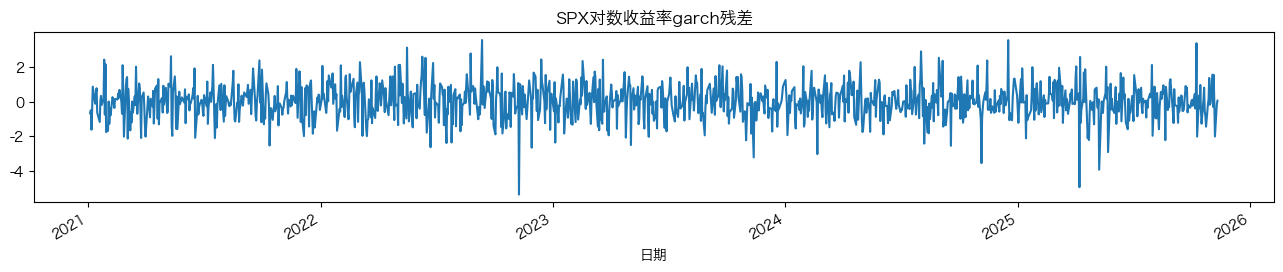

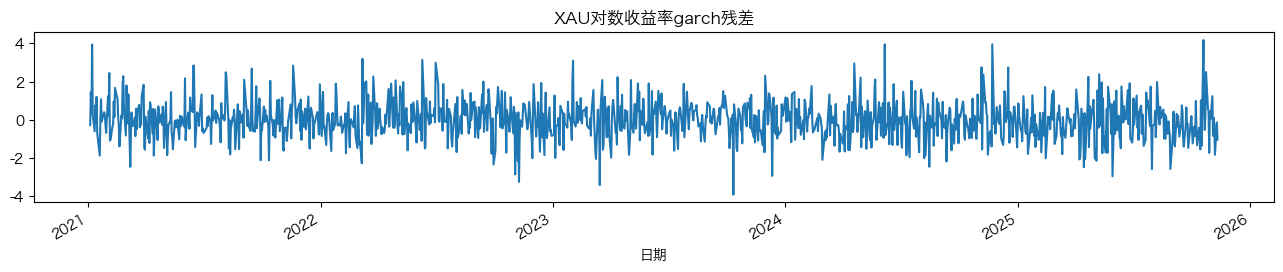

In [35]:
[(std_resid[col].plot(figsize=(16,2.5),title = col+'对数收益率garch残差'),plt.show()) for col in std_resid.columns]
_ = 0

In [40]:
[display(name,group.corr()) for name,group in std_resid.groupby(std_resid.index.year)]
std_resid.describe()

2021

,BTC,ETH,SPX,XAU
BTC,1.000000,0.759845,0.256900,-0.045686
ETH,0.759845,1.000000,0.247396,0.009088
SPX,0.256900,0.247396,1.000000,0.157900
XAU,-0.045686,0.009088,0.157900,1.000000


2022

,BTC,ETH,SPX,XAU
BTC,1.000000,0.894201,0.577966,0.170514
ETH,0.894201,1.000000,0.569732,0.151483
SPX,0.577966,0.569732,1.000000,0.213571
XAU,0.170514,0.151483,0.213571,1.000000


2023

,BTC,ETH,SPX,XAU
BTC,1.000000,0.852058,0.140237,0.097550
ETH,0.852058,1.000000,0.158163,0.104922
SPX,0.140237,0.158163,1.000000,0.022642
XAU,0.097550,0.104922,0.022642,1.000000


2024

,BTC,ETH,SPX,XAU
BTC,1.000000,0.804685,0.354298,0.118910
ETH,0.804685,1.000000,0.370500,0.127510
SPX,0.354298,0.370500,1.000000,0.225257
XAU,0.118910,0.127510,0.225257,1.000000


2025

,BTC,ETH,SPX,XAU
BTC,1.000000,0.792044,0.464908,0.060803
ETH,0.792044,1.000000,0.526558,-0.027292
SPX,0.464908,0.526558,1.000000,-0.147061
XAU,0.060803,-0.027292,-0.147061,1.000000


,BTC,ETH,SPX,XAU
count,1221.000000,1221.000000,1221.000000,1221.000000
mean,0.000362,-0.000990,0.001966,-0.005732
std,1.000082,1.000547,1.000609,1.002485
min,-5.019513,-5.090798,-5.345559,-3.906356
25%,-0.514769,-0.523908,-0.580913,-0.599259
50%,0.030045,0.001603,0.015892,-0.032946
75%,0.516873,0.528636,0.575232,0.575815
max,6.304010,4.998446,3.537369,4.179564


## copula拟合

In [11]:
u = pseudo_obs(std_resid.values)
print(f"伪观测 U 形状: {u.shape}")
std_resid['BTC']

伪观测 U 形状: (1221, 4)


日期
2025-11-11    0.579320
2025-11-10    1.164915
2025-11-07   -0.927727
2025-11-06   -0.688772
2025-11-05    1.000478
                ...   
2021-01-08    2.201985
2021-01-07   -0.392046
2021-01-06   -1.032582
2021-01-05   -1.174918
2021-01-04   -0.872341
Name: BTC, Length: 1221, dtype: float64

In [36]:
gcop = GaussianCopula(dim = 2)
gcop_res = gcop.fit(u[:,0:2])
gcop_res.summary()

1.00000,0.82394
0.82394,1.00000


In [13]:
gcop_res.log_lik(u[:,0:2])

np.float64(688.4951067107049)

In [14]:
tcop = StudentCopula(dim=2)
tcop_res = tcop.fit(u[:,0:2])
tcop_res.summary()

1.000000,0.806412
0.806412,1.000000


In [15]:
ccop = ClaytonCopula(dim=2)
ccop_res = ccop.fit(u[:,0:2])
ccop_res.summary()

Clayton Copula Summary
================================================================================
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.8698668477639497

In [16]:
tcop.params

StudentParams(df=np.float64(7.407408020299044e-13), rho=array([0.80641227]))

In [17]:
def fit_gaussian(u, indep=False):
    """GaussianCopula（indep=True 为 IndepCopula 模拟）"""
    cop = GaussianCopula(dim=4)
    if indep:
        cop.rho = np.eye(4)  # 独立模式
        loglik = np.sum(np.log(np.prod(stats.norm.pdf(stats.norm.ppf(u)), axis=1) + 1e-10))
    else:
        cop.fit(u)
        loglik = cop.log_lik(u)
    return {'name': 'IndepCopula' if indep else 'GaussianCopula', 'rho': cop.rho, 'loglik': loglik}

def fit_student(u):
    """StudentCopula (t-Copula)"""
    cop = StudentCopula(dim=4)
    cop.fit(u)
    return {'name': 'StudentCopula (t)', 'rho': cop.rho, 'df': cop.df, 'loglik': cop.log_lik(u)}

def fit_clayton(u):
    """ClaytonCopula (下尾)"""
    cop = ClaytonCopula(dim=4)
    cop.fit(u)
    return {'name': 'ClaytonCopula (下尾)', 'theta': cop.params[0], 'loglik': cop.log_lik(u)}

def fit_gumbel(u):
    """GumbelCopula (上尾)"""
    cop = GumbelCopula(dim=4)
    cop.fit(u)
    return {'name': 'GumbelCopula (上尾)', 'theta': cop.params[0], 'loglik': cop.log_lik(u)}

def fit_frank(u):
    """FrankCopula"""
    cop = FrankCopula(dim=4)
    cop.fit(u)
    return {'name': 'FrankCopula', 'theta': cop.params[0], 'loglik': cop.log_lik(u)}

def fit_rot_clayton(u):
    """旋转 Clayton (上尾): fit Clayton to 1-U"""
    u_rot = 1 - u
    cop = ClaytonCopula(dim=4)
    cop.fit(u_rot)
    loglik_rot = cop.log_lik(u_rot)
    return {'name': 'Rot-Clayton (上尾)', 'theta': cop.params[0], 'loglik': loglik_rot}

def fit_rot_gumbel(u):
    """旋转 Gumbel (下尾): fit Gumbel to 1-U"""
    u_rot = 1 - u
    cop = GumbelCopula(dim=4)
    cop.fit(u_rot)
    loglik_rot = cop.log_lik(u_rot)
    return {'name': 'Rot-Gumbel (下尾)', 'theta': cop.params[0], 'loglik': loglik_rot}

def fit_empirical(u):
    """EmpiricalCopula (非参数)"""
    cop = EmpiricalCopula(u)
    return {'name': 'EmpiricalCopula', 'loglik': cop.log_lik(u)}  # 经验似然



In [18]:

fit_funcs = [
    lambda u: fit_gaussian(u, indep=True),  # IndepCopula
    lambda u: fit_gaussian(u),              # Gaussian
    fit_student,                            # t
    fit_clayton,                            # Clayton
    fit_gumbel,                             # Gumbel
    fit_frank,                              # Frank
    fit_rot_clayton,                        # Rot-Clayton
    fit_rot_gumbel,                         # Rot-Gumbel
    fit_empirical                           # Empirical
]
results = []
for fit_func in fit_funcs:
    try:
        res = fit_func(u)
        # 参数数估算 (AIC/BIC)
        n_param = len(res.get('params', [])) if 'params' in res else (6 if 'rho' in res else 1)
        aic = -2 * res['loglik'] + 2 * n_param
        bic = -2 * res['loglik'] + np.log(len(u)) * n_param
        results.append({**res, 'AIC': aic, 'BIC': bic, 'n_param': n_param})
        print(f"{res['name']}: AIC={aic:.2f}")
    except Exception as e:
        print(f"{fit_func.__name__}: 失败 {e}（小数据常见）")

<lambda>: 失败 property 'rho' of 'GaussianCopula' object has no setter（小数据常见）
GaussianCopula: AIC=-1585.76
fit_student: 失败 'StudentCopula' object has no attribute 'df'（小数据常见）
fit_clayton: 失败 'float' object is not subscriptable（小数据常见）
fit_gumbel: 失败 'float' object is not subscriptable（小数据常见）
fit_frank: 失败 'float' object is not subscriptable（小数据常见）
fit_rot_clayton: 失败 'float' object is not subscriptable（小数据常见）
fit_rot_gumbel: 失败 'float' object is not subscriptable（小数据常见）
fit_empirical: 失败 Empirical Copula only has density (PDF) for 'beta' smoothing（小数据常见）


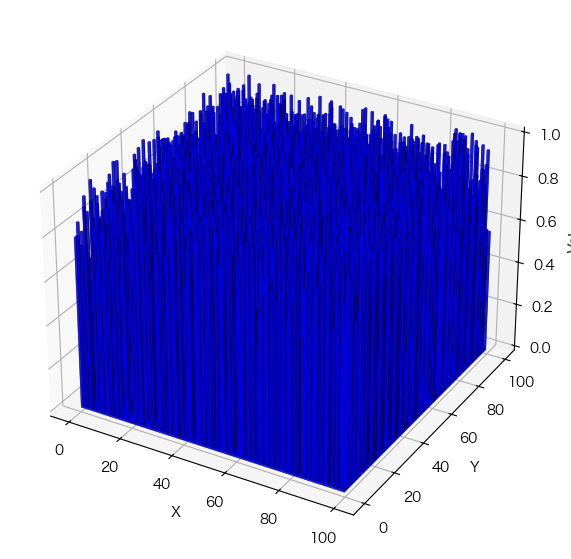

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 您的热力图数据（替换为实际数据）
data = np.random.rand(100, 100)

# 简洁的3D柱状图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(range(data.shape[1]), range(data.shape[0]))
x, y = x.flatten(), y.flatten()
z = np.zeros_like(x)
dz = data.flatten()

ax.bar3d(x, y, z, 0.8, 0.8, dz, 
         color='Blue',    # 柱子颜色
         alpha=0.7)           # 透明度

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
plt.show()

In [20]:
[display(n,g.corr()) for n,g in std_resid.groupby(std_resid.index.year)]

2021

,BTC,ETH,SPX,XAU
BTC,1.000000,0.759845,0.256900,-0.045686
ETH,0.759845,1.000000,0.247396,0.009088
SPX,0.256900,0.247396,1.000000,0.157900
XAU,-0.045686,0.009088,0.157900,1.000000


2022

,BTC,ETH,SPX,XAU
BTC,1.000000,0.894201,0.577966,0.170514
ETH,0.894201,1.000000,0.569732,0.151483
SPX,0.577966,0.569732,1.000000,0.213571
XAU,0.170514,0.151483,0.213571,1.000000


2023

,BTC,ETH,SPX,XAU
BTC,1.000000,0.852058,0.140237,0.097550
ETH,0.852058,1.000000,0.158163,0.104922
SPX,0.140237,0.158163,1.000000,0.022642
XAU,0.097550,0.104922,0.022642,1.000000


2024

,BTC,ETH,SPX,XAU
BTC,1.000000,0.804685,0.354298,0.118910
ETH,0.804685,1.000000,0.370500,0.127510
SPX,0.354298,0.370500,1.000000,0.225257
XAU,0.118910,0.127510,0.225257,1.000000


2025

,BTC,ETH,SPX,XAU
BTC,1.000000,0.792044,0.464908,0.060803
ETH,0.792044,1.000000,0.526558,-0.027292
SPX,0.464908,0.526558,1.000000,-0.147061
XAU,0.060803,-0.027292,-0.147061,1.000000


[None, None, None, None, None]

In [21]:
[display(n,g.corr()) for n,g in log_ret.groupby(log_ret.index.year)]

2021

,BTC,ETH,SPX,XAU
BTC,1.000000,0.751278,0.274711,-0.057903
ETH,0.751278,1.000000,0.247732,0.022937
SPX,0.274711,0.247732,1.000000,0.151978
XAU,-0.057903,0.022937,0.151978,1.000000


2022

,BTC,ETH,SPX,XAU
BTC,1.000000,0.904812,0.560972,0.139163
ETH,0.904812,1.000000,0.546193,0.124560
SPX,0.560972,0.546193,1.000000,0.194101
XAU,0.139163,0.124560,0.194101,1.000000


2023

,BTC,ETH,SPX,XAU
BTC,1.000000,0.853477,0.151674,0.103835
ETH,0.853477,1.000000,0.151855,0.104792
SPX,0.151674,0.151855,1.000000,-0.013418
XAU,0.103835,0.104792,-0.013418,1.000000


2024

,BTC,ETH,SPX,XAU
BTC,1.000000,0.820476,0.366613,0.092178
ETH,0.820476,1.000000,0.400753,0.117460
SPX,0.366613,0.400753,1.000000,0.239333
XAU,0.092178,0.117460,0.239333,1.000000


2025

,BTC,ETH,SPX,XAU
BTC,1.000000,0.801473,0.424022,0.077800
ETH,0.801473,1.000000,0.461157,-0.009235
SPX,0.424022,0.461157,1.000000,-0.023464
XAU,0.077800,-0.009235,-0.023464,1.000000


[None, None, None, None, None]